# XGBOOST BASELINE for Semeval - Laptops 2016 joint

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [0]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt


from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix, classification_report

## Preprocessing

Function to add [CLS] and [SEP] as separator tokens at beginning/ending of each text item and to format aspect and polarity columns as lists:

In [0]:
def changeFormat(dataset):

  df = pd.DataFrame(dataset)
  text = df['text']
  joint = df['joint']
  df2 = pd.DataFrame({'text': '[CLS] ' + text + ' [SEP]',
                    'joint': joint})
  
  df2['joint'] = [x.split(',') for x in df2['joint']]
  
  return df2

Read csv files from Google Drive (directly from shared group drive "NLP Lab"):

In [0]:
L16_train = pd.read_csv("/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/DataPreprocessing/Data_Final/Train data/semevalLaptops_16_joint_train.csv")

In [5]:
L16_train = changeFormat(L16_train)
L16_train.head()

,text,joint
0,"[CLS] Will not buy another Toshiba, this is my...","[COMPANY#GENERAL/negative, LAPTOP#GENERAL/nega..."
1,[CLS] The desktop was clean once I got it up a...,[LAPTOP#DESIGN_FEATURES/positive]
2,"[CLS] I tell everyone that I know, friends, fa...",[LAPTOP#GENERAL/negative]
3,[CLS] My first problem was with the pre-loaded...,[SOFTWARE#GENERAL/negative]
4,[CLS] 7.Expensive. [SEP],[LAPTOP#PRICE/negative]


In [0]:
L16_test = pd.read_csv("/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/DataPreprocessing/Data_Final/Test data/semevalLaptops_16_joint_test.csv")

In [7]:
L16_test = changeFormat(L16_test)
L16_test.head()

,text,joint
0,[CLS] Heavy gaming is definitely not it's stro...,[LAPTOP#MISCELLANEOUS/negative]
1,[CLS] Don't waste your money! [SEP],[LAPTOP#GENERAL/negative]
2,[CLS] The only major negative to me is Windows...,"[OS#GENERAL/negative, LAPTOP#DESIGN_FEATURES/n..."
3,[CLS] The big deal with this was Windows 7. [SEP],[OS#GENERAL/positive]
4,[CLS] This is likely due to poor grounding and...,"[LAPTOP#PRICE/neutral, HARDWARE#QUALITY/negative]"


Shape of the train and test data:

In [8]:
L16_train.shape

(1626, 2)

In [9]:
L16_test.shape

(407, 2)

##**BERT embeddings**

Preprocessing to import BERT embeddings file of group in Colab

In [10]:
!pip install pytorch-pretrained-bert

In [11]:
!pwd

/content


In [12]:
%cd "/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/baseline"

/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/baseline


In [13]:
!ls

embeddings.py  Laptop  __pycache__  Restaurant


In [0]:
from embeddings import Embeddings

In [0]:
embed = Embeddings()

Get BERT embeddings for train and test data:

In [0]:
L16_train_embeddings = embed.get_embeddings(L16_train.text, all=False)
L16_test_embeddings = embed.get_embeddings(L16_test.text, all=False)

Plausibility check

In [17]:
# number of vectors 
len(L16_train_embeddings[0])

21

In [18]:
#string is counted letter per letter
len(L16_train['text'][0])

81

In [19]:
# original text
L16_train['text'][0]

'[CLS] Will not buy another Toshiba, this is my second, not happy w/ either. [SEP]'

In [20]:
# vectors
L16_train_embeddings[0]

tensor([[-0.2536,  0.2202,  0.1952,  ..., -0.5029,  0.4658,  0.3864],
        [ 0.8805, -0.0664,  0.4623,  ..., -0.4154,  0.6296,  0.4003],
        [ 0.6013, -0.4148,  0.3389,  ..., -0.3698,  0.3827, -0.2901],
        ...,
        [ 0.0863, -0.2756,  0.6594,  ..., -0.3057,  0.7873, -0.2380],
        [ 0.0133,  0.1062, -0.1878,  ...,  0.1243, -0.1127, -0.5372],
        [ 0.5421,  0.3402, -0.2915,  ..., -0.2706, -0.4420, -0.2399]])

In [21]:
len(L16_test_embeddings[0])

13

In [22]:
L16_test['text'][0]

"[CLS] Heavy gaming is definitely not it's strong point. [SEP]"

In [0]:
L16_train['embeddings'] = [e[0].numpy() for e in L16_train_embeddings]
L16_test['embeddings'] = [e[0].numpy() for e in L16_test_embeddings]

##**XGBOOST Baseline Model for Joint aspect and polarity**

In [24]:
L16_joint = MultiLabelBinarizer()
L16_joint.fit(L16_train.joint)
L16_joint.classes_

array(['BATTERY#MISCELLANEOUS/negative',
       'BATTERY#OPERATION_PERFORMANCE/negative',
       'BATTERY#OPERATION_PERFORMANCE/neutral',
       'BATTERY#OPERATION_PERFORMANCE/positive',
       'BATTERY#QUALITY/negative', 'BATTERY#QUALITY/neutral',
       'COMPANY#GENERAL/negative', 'COMPANY#GENERAL/neutral',
       'COMPANY#GENERAL/positive', 'CPU#DESIGN_FEATURES/neutral',
       'CPU#MISCELLANEOUS/neutral', 'CPU#OPERATION_PERFORMANCE/negative',
       'CPU#OPERATION_PERFORMANCE/positive', 'CPU#QUALITY/negative',
       'DISPLAY#DESIGN_FEATURES/negative',
       'DISPLAY#DESIGN_FEATURES/neutral',
       'DISPLAY#DESIGN_FEATURES/positive', 'DISPLAY#GENERAL/negative',
       'DISPLAY#GENERAL/positive',
       'DISPLAY#OPERATION_PERFORMANCE/negative',
       'DISPLAY#OPERATION_PERFORMANCE/positive',
       'DISPLAY#QUALITY/negative', 'DISPLAY#QUALITY/positive',
       'DISPLAY#USABILITY/negative', 'DISPLAY#USABILITY/positive',
       'FANS_COOLING#DESIGN_FEATURES/positive',
       'FANS_

In [25]:
y_L16_train_joint = L16_joint.transform(L16_train.joint)
y_L16_test_joint = L16_joint.transform(L16_test.joint)
y_L16_train_joint[3]

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:951: UserWarning: unknown class(es) ['BATTERY#QUALITY/positive', 'CPU#QUALITY/positive', 'DISPLAY#GENERAL/neutral', 'DISPLAY#OPERATION_PERFORMANCE/neutral', 'DISPLAY#QUALITY/neutral', 'DISPLAY#USABILITY/neutral', 'GRAPHICS#MISCELLANEOUS/negative', 'GRAPHICS#MISCELLANEOUS/positive', 'KEYBOARD#OPERATION_PERFORMANCE/positive', 'LAPTOP#PORTABILITY/neutral', 'MOUSE#QUALITY/neutral', 'OPTICAL_DRIVES#OPERATION_PERFORMANCE/negative', 'PORTS#OPERATION_PERFORMANCE/negative', 'SHIPPING#PRICE/negative', 'SOFTWARE#GENERAL/neutral'] will be ignored
  .format(sorted(unknown, key=str)))


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [26]:
L16_xgb_joint = OneVsRestClassifier(XGBClassifier(objective='binary:logistic', n_estimators=500 , max_depth=3,
                                               learning_rate=0.05, n_jobs=24, verbosity=1,
                                               min_child_weight=20, scale_pos_weight=6, base_score=0.2))
L16_xgb_joint.fit(np.array(list(L16_train.embeddings)), y_L16_train_joint)

OneVsRestClassifier(estimator=XGBClassifier(base_score=0.2, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.05,
                                            max_delta_step=0, max_depth=3,
                                            min_child_weight=20, missing=None,
                                            n_estimators=500, n_jobs=24,
                                            nthread=None,
                                            objective='binary:logistic',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=6,
                                            seed=None, silent=None, subsample=1,
                                            verbosity=1),
        

In [27]:
L16_joint_report = classification_report(y_L16_test_joint, L16_xgb_joint.predict(np.array(list(L16_test.embeddings))),
                            target_names=L16_joint.classes_, output_dict=True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


Text(0.5, 1.0, 'Multi-label aspect classification performance')

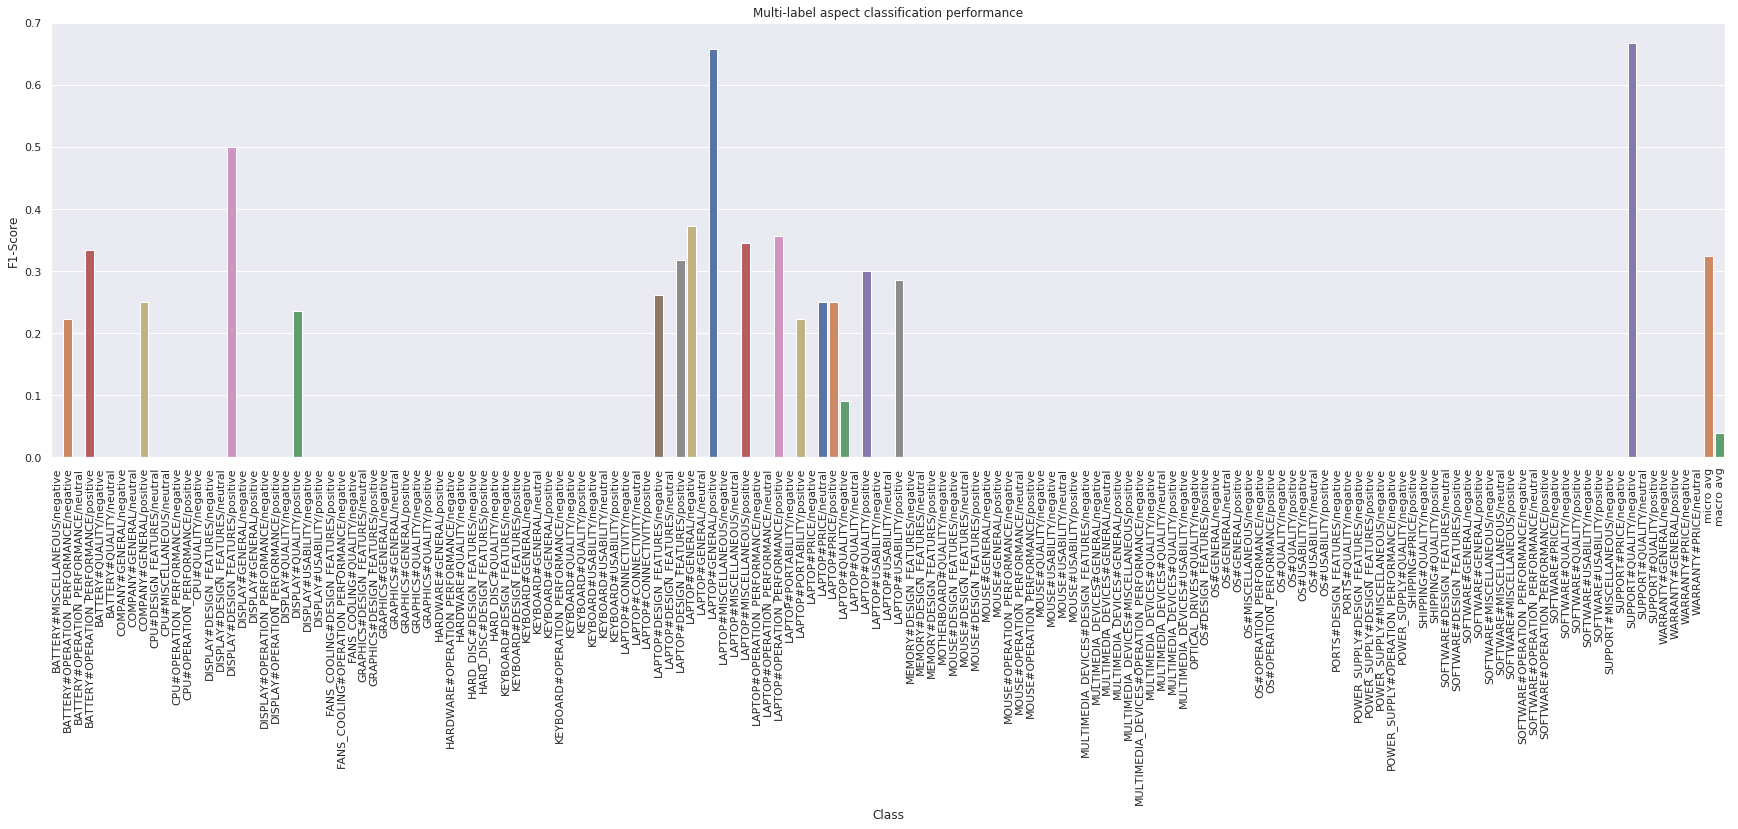

In [30]:
L16_f1s_joint = []
for key in L16_joint_report.keys():
    L16_f1s_joint.append(L16_joint_report.get(key).get('f1-score'))

sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(30,8)})
sns.barplot(list(L16_joint_report.keys())[:-2], L16_f1s_joint[:-2], palette='deep')
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.title('Multi-label aspect classification performance')

In [29]:
[plt.text(v, i, '{:.2f}'.format(v)) for i, v in enumerate(L16_f1s_joint[:-2])]

[Text(0.0, 0, '0.00'),
 Text(0.2222222222222222, 1, '0.22'),
 Text(0.0, 2, '0.00'),
 Text(0.33333333333333337, 3, '0.33'),
 Text(0.0, 4, '0.00'),
 Text(0.0, 5, '0.00'),
 Text(0.0, 6, '0.00'),
 Text(0.0, 7, '0.00'),
 Text(0.25, 8, '0.25'),
 Text(0.0, 9, '0.00'),
 Text(0.0, 10, '0.00'),
 Text(0.0, 11, '0.00'),
 Text(0.0, 12, '0.00'),
 Text(0.0, 13, '0.00'),
 Text(0.0, 14, '0.00'),
 Text(0.0, 15, '0.00'),
 Text(0.5, 16, '0.50'),
 Text(0.0, 17, '0.00'),
 Text(0.0, 18, '0.00'),
 Text(0.0, 19, '0.00'),
 Text(0.0, 20, '0.00'),
 Text(0.0, 21, '0.00'),
 Text(0.23529411764705885, 22, '0.24'),
 Text(0.0, 23, '0.00'),
 Text(0.0, 24, '0.00'),
 Text(0.0, 25, '0.00'),
 Text(0.0, 26, '0.00'),
 Text(0.0, 27, '0.00'),
 Text(0.0, 28, '0.00'),
 Text(0.0, 29, '0.00'),
 Text(0.0, 30, '0.00'),
 Text(0.0, 31, '0.00'),
 Text(0.0, 32, '0.00'),
 Text(0.0, 33, '0.00'),
 Text(0.0, 34, '0.00'),
 Text(0.0, 35, '0.00'),
 Text(0.0, 36, '0.00'),
 Text(0.0, 37, '0.00'),
 Text(0.0, 38, '0.00'),
 Text(0.0, 39, '0.00'),
 T

ValueError: ignored

<Figure size 1440x576 with 1 Axes>